# Predtekmovanje - ena linija

In [323]:
import pandas as pd
import numpy as np
from datetime import date, datetime, timedelta
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

## Load the data

In [370]:
train = pd.read_csv('train_pred.csv', sep='\t')
test = pd.read_csv('test_pred.csv', sep='\t')

weather_data = pd.read_csv('weather_data.csv', sep='\t', index_col=0)
prazniki = pd.read_csv('prazniki_prosti.txt', sep='\t', index_col=0, header=None)
pocitnice = pd.read_csv('pocitnice.txt', sep='\t', index_col=0, header=None)

In [429]:
train

,Registration,Driver ID,Route,Route Direction,Route description,First station,Departure time,Last station,Arrival time
0,LJ LPP-161,230,14,SAVLJE - VRHOVCI,VRHOVCI,Kališnikov trg,2012-01-13 12:27:04.000,VRHOVCI,2012-01-13 13:00:33.000
1,LJ LPP-161,231,14,SAVLJE - VRHOVCI,VRHOVCI,Kališnikov trg,2012-01-13 15:46:19.000,VRHOVCI,2012-01-13 16:19:21.000
2,LJ LPP-161,231,14,SAVLJE - VRHOVCI,VRHOVCI,Kališnikov trg,2012-01-13 17:21:55.000,VRHOVCI,2012-01-13 18:01:00.000
3,LJ LPP-161,231,14,SAVLJE - VRHOVCI,VRHOVCI,Kališnikov trg,2012-01-13 20:29:59.000,VRHOVCI,2012-01-13 21:01:39.000
4,LJ LPP-200,58,14,SAVLJE - VRHOVCI,VRHOVCI,Kališnikov trg,2012-01-12 12:49:53.000,VRHOVCI,2012-01-12 13:23:31.000
...,...,...,...,...,...,...,...,...,...
9479,LJ LPP-449,98,14,SAVLJE - VRHOVCI,VRHOVCI,Kališnikov trg,2012-11-26 13:12:21.000,VRHOVCI,2012-11-26 13:47:42.000
9480,LJ LPP-449,98,14,SAVLJE - VRHOVCI,VRHOVCI,Kališnikov trg,2012-11-26 16:32:01.000,VRHOVCI,2012-11-26 17:08:11.000
9481,LP LPP-392,141,14,SAVLJE - VRHOVCI,VRHOVCI,Kališnikov trg,2012-11-26 05:31:55.000,VRHOVCI,2012-11-26 06:07:31.000
9482,LP LPP-392,271,14,SAVLJE - VRHOVCI,VRHOVCI,Kališnikov trg,2012-11-26 11:44:29.000,VRHOVCI,2012-11-26 12:20:47.000


In [4]:
weather_data

,t2m,rh,padavine,veter_hitrost
min1800,,,,
111500640,-0.4,92,0.0,1.1
111500670,-0.5,92,0.0,0.9
111500700,-0.5,92,0.0,0.7
111500730,-0.5,92,0.0,0.8
111500760,-0.6,92,0.0,0.7
...,...,...,...,...
112027530,-1.2,96,0.0,0.7
112027560,-1.4,96,0.0,1.3
112027590,-1.4,96,0.0,0.6


In [371]:
pocitnice

,1
0,
2012-01-02,1
2012-02-20,1
2012-02-21,1
2012-02-22,1
2012-02-23,1
...,...
2012-12-27,1
2012-12-28,1
2012-12-29,1


## Preproscessing

In [372]:
def convert(data):
	d = pd.DataFrame()
	d['departure'] = pd.to_datetime(data['Departure time'])
	d['weekday'] = d['departure'].dt.weekday
	d['month'] = d['departure'].dt.month
	d['hour'] = d['departure'].dt.hour
	d['minute'] = d['departure'].dt.hour*60 + d['departure'].dt.minute
	d['yearday'] = d['departure'].dt.day_of_year
	d['driver'] = data['Driver ID']
	d['weather_key'] = ((d['departure'].copy().round('30min') - pd.to_datetime(date(1800,1,1))).dt.total_seconds()//60).astype(int)
	d['holiday'] = d['departure'].dt.strftime('%Y-%m-%d').isin(prazniki.index).astype(int)
	d['school_holiday'] = d['departure'].dt.strftime('%Y-%m-%d').isin(pocitnice.index).astype(int)

	# merge weather data
	d = pd.merge(d, weather_data, left_on='weather_key', right_index=True, how="left")
	d['freezing'] = (d['t2m'] < 0).astype(int)
	return d

In [417]:
def get_X_train_test(train, test):
	enc = OneHotEncoder(sparse=False)
	poly_yearday = PolynomialFeatures(degree=2, include_bias=True)
	poly_minute = PolynomialFeatures(degree=4, include_bias=True)
	poly_weather = PolynomialFeatures(degree=2, include_bias=True)
	poly_weekday = PolynomialFeatures(degree=2, include_bias=True)
	scaler_yearday = StandardScaler()
	scaler_minute = StandardScaler()
	scaler_weather = StandardScaler()
	scaler_weekday = StandardScaler()

	d = convert(train.append(test))

	t1 = enc.fit_transform(d[['weekday', 'driver', 'holiday', 'hour', 'freezing', 'school_holiday']].values)

	t2 = d[['yearday']].values
	t2 = scaler_yearday.fit_transform(t2)
	t2 = poly_yearday.fit_transform(t2)
	
	t3 = d[['minute']].values / 60
	t3 = scaler_minute.fit_transform(t3)
	t3 = poly_minute.fit_transform(t3)

	t4 = d[['t2m', 'padavine', 'veter_hitrost']].values
	t4 = scaler_weather.fit_transform(t4)
	t4 = poly_weather.fit_transform(t4)

	t5 = d[['weekday']].values
	t5 = scaler_weekday.fit_transform(t5)
	t5 = poly_weekday.fit_transform(t5)

	t = np.hstack((t1, t2, t3, t4, t5))

	return t[:len(train)], t[len(train):], d[:len(train)]

def get_y_train(data):
	d = pd.DataFrame()
	d['departure'] = pd.to_datetime(data['Departure time'])	
	d['arrival'] = pd.to_datetime(data['Arrival time'])
	d['duration'] = (d['arrival'] - d['departure']).dt.total_seconds()

	return d['duration'].to_numpy()


def get_result(data, prediction):
	result = (pd.to_datetime(data['Departure time']) + pd.to_timedelta(prediction, unit='s')).round('1ms')
	return result

## Test

In [433]:
X_train, X_test, d = get_X_train_test(train, test)
y_train = get_y_train(train)

# split into train and test
n = 2000
X_train_eval = X_train[:-n]
y_train_eval = y_train[:-n]
X_train_eval_test = X_train[-n:]
y_train_eval_test = y_train[-n:]

# train the model
reg = Ridge(alpha=3).fit(X_train_eval, y_train_eval)

# predict
y_train_eval_test_pred = reg.predict(X_train_eval_test)

# compute MAE
mae = np.mean(np.abs(y_train_eval_test_pred - y_train_eval_test))

print(f"MAE: {mae}")

# MAE: 127.00, 126.01, 125.99

MAE: 125.98914043362875


In [435]:
# train on the whole dataset
reg = Ridge(alpha=3).fit(X_train, y_train)

y_test_pred = reg.predict(X_test)

result = get_result(test, y_test_pred)
result.to_csv('result7.txt', index=False, header=False)

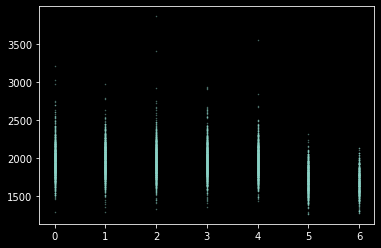

In [411]:
plt.scatter(d["weekday"].values, y_train, s=1, alpha=0.5, marker=".")

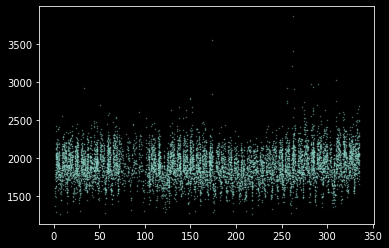

In [419]:
plt.scatter(d["yearday"].values, y_train, s=1, alpha=0.5, marker=".")


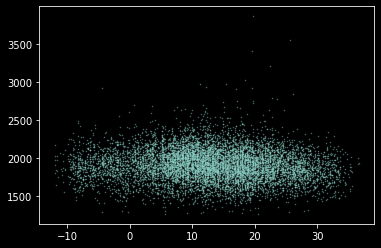

In [420]:
plt.scatter(d["t2m"].values, y_train, s=1, alpha=0.5, marker=".")

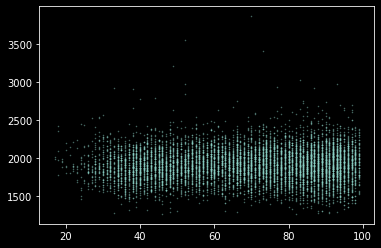

In [424]:
plt.scatter(d["rh"].values, y_train, s=1, alpha=0.5, marker=".")

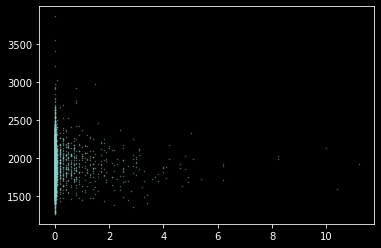

In [425]:
plt.scatter(d["padavine"].values, y_train, s=1, alpha=0.5, marker=".")

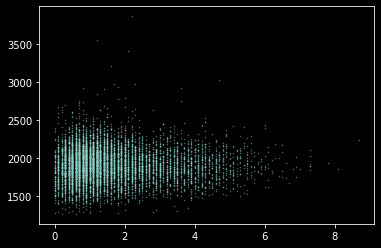

In [428]:
plt.scatter(d["veter_hitrost"].values, y_train, s=1, alpha=0.5, marker=".")
